In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
# from https://github.com/hauser-group/odft_tools
from odft_tools.layers import IntegrateLayer

# Load dataset
Both data .hdf5-Files can be downloaded from https://github.com/hauser-group/datasets/tree/master/orbital_free_DFT

### Training

In [2]:
with h5py.File('M=100_training_data.hdf5', 'r') as f:
    keys = f.keys()
    print(keys)
    # build a dict (dataset.value has been deprecated. Use dataset[()] instead.)
    data = {key:f[key][()] for key in keys}

<KeysViewHDF5 ['energies', 'potential', 'wavefunctions']>


In [3]:
x = np.linspace(0, 1, 500)
dx = x[1] - x[0]
N = 1
# density is wavefunction squared
n = np.sum(data['wavefunctions'][:, :, :N]**2, axis=-1)
# integrate using trapezoidal rule:
V = np.sum(0.5*(data['potential'][:, :-1]*n[:, :-1] 
                + data['potential'][:, 1:]*n[:, 1:])           
           * dx, axis=-1)
# kinetic energy is total energy minus potential energy
T = np.sum(data['energies'][:, :N], axis=-1) - V
# kinetic energy derivative
dT_dn = np.expand_dims(np.sum(data['energies'][:, :N], axis=-1)/N, axis=-1) - data['potential']
n = n.reshape((-1, 500, 1))

### Test Set

In [4]:
with h5py.File('test_data.hdf5', 'r') as f:
    keys = f.keys()
    print(keys)
    # build a dict (dataset.value has been deprecated. Use dataset[()] instead.)
    data_test = {key:f[key][()] for key in keys}

<KeysViewHDF5 ['energies', 'potential', 'wavefunctions']>


In [5]:
# density is wavefunction squared
n_test = np.sum(data_test['wavefunctions'][:, :, :N]**2, axis=-1)
# integrate using trapezoidal rule:
V_test = np.sum(0.5*(data_test['potential'][:, :-1]*n_test[:, :-1] 
                + data_test['potential'][:, 1:]*n_test[:, 1:])           
                * dx, axis=-1)
# kinetic energy is total energy minus potential energy
T_test = np.sum(data_test['energies'][:, :N], axis=-1) - V_test
# kinetic energy derivative
dT_dn_test = - data_test['potential'] + np.expand_dims(np.sum(data_test['energies'][:, :N], axis=-1)/N, axis=-1) 
n_test = n_test.reshape((-1, 500, 1))

# Define model

In [6]:
class MyModel(tf.keras.Model):

    def __init__(self, layers=[32,], kernel_size=64, dx=1.0):
        super(MyModel, self).__init__()
        self.dx = dx
        self.conv_layers = []
        for l in layers:
            self.conv_layers.append(tf.keras.layers.Conv1D(l, kernel_size, padding='same', activation='softplus'))
        # last layer is fixed to use a single filter
        self.conv_layers.append(tf.keras.layers.Conv1D(1, kernel_size, padding='same', activation='linear'))
        self.integrate = IntegrateLayer(dx)

    @tf.function
    def call(self, inputs):
        with tf.GradientTape() as tape:
            tape.watch(inputs)
            # Calculate kinetic energy density tau by applying convolutional layers
            tau = inputs
            for layer in self.conv_layers:
                tau = layer(tau)
            # Kinetic energy T is integral over kinetiv energy density
            T = self.integrate(tau)
        # The discretized derivative needs to be divided by dx
        dT_dn = tape.gradient(T, inputs)/self.dx
        return {'T': T, 'dT_dn': dT_dn}

In [7]:
# Feel free to use larger kernel size (Manuel used 100) and larger networks (Manuels ResNet used layers=[32, 32, 32, 32, 32, 32]).
model = MyModel(layers=[32,], kernel_size=64, dx=dx)
# Tell the model what input to expect. The first dimension (None) represents the batch size and remains undefinded.
model.build(input_shape=(None, 500, 1))

In [8]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
              loss={'T': 'mse', 'dT_dn': 'mse'}, 
              loss_weights={'T': 0.2, 'dT_dn': 1.0}, # As recommended by Manuel: scale the loss in T by 0.2
              metrics={'T': ['mae'], 'dT_dn': ['mae']})
model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              multiple                  2080      
_________________________________________________________________
conv1d_1 (Conv1D)            multiple                  2049      
_________________________________________________________________
integrate_layer (IntegrateLa multiple                  0         
Total params: 4,129
Trainable params: 4,129
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Build a dataset that repeats the data (cast to float32) 10 times to reduce output in model.fit().
# Note that this step is not necessary, you could simply feed the numpy arrays into the model.fit() method.
training_dataset = tf.data.Dataset.from_tensor_slices((n.astype(np.float32), {'T': T.astype(np.float32), 'dT_dn': dT_dn.astype(np.float32)})).batch(100).repeat(10)

In [10]:
# Beware when comparing the results to our paper. The output here is in Hartree!
model.fit(training_dataset, epochs=50, verbose=2, validation_data=(n_test, {'T': T_test, 'dT_dn': dT_dn_test}), validation_freq=10)

Epoch 1/50
10/10 - 8s - loss: 21.3169 - T_loss: 9.3163 - dT_dn_loss: 19.4537 - T_mae: 2.7912 - dT_dn_mae: 3.2944
Epoch 2/50
10/10 - 8s - loss: 16.1458 - T_loss: 1.2006 - dT_dn_loss: 15.9057 - T_mae: 0.7640 - dT_dn_mae: 2.9781
Epoch 3/50
10/10 - 8s - loss: 11.9761 - T_loss: 1.6276 - dT_dn_loss: 11.6506 - T_mae: 1.1930 - dT_dn_mae: 2.6402
Epoch 4/50
10/10 - 8s - loss: 11.0431 - T_loss: 0.2355 - dT_dn_loss: 10.9960 - T_mae: 0.4368 - dT_dn_mae: 2.6521
Epoch 5/50
10/10 - 8s - loss: 10.2160 - T_loss: 0.1635 - dT_dn_loss: 10.1833 - T_mae: 0.3475 - dT_dn_mae: 2.5286
Epoch 6/50
10/10 - 8s - loss: 9.6676 - T_loss: 0.5036 - dT_dn_loss: 9.5669 - T_mae: 0.6619 - dT_dn_mae: 2.4262
Epoch 7/50
10/10 - 8s - loss: 9.2230 - T_loss: 0.1135 - dT_dn_loss: 9.2003 - T_mae: 0.2751 - dT_dn_mae: 2.4121
Epoch 8/50
10/10 - 8s - loss: 8.9001 - T_loss: 0.0766 - dT_dn_loss: 8.8848 - T_mae: 0.2400 - dT_dn_mae: 2.3737
Epoch 9/50
10/10 - 8s - loss: 8.6256 - T_loss: 0.1040 - dT_dn_loss: 8.6048 - T_mae: 0.2919 - dT_dn_mae

## Inspect results
The prediction by the CNN exhibits rapid oscillations, which we hope to eliminate by going from a convolution with a discrete kernel towards a convolution with a continuous function

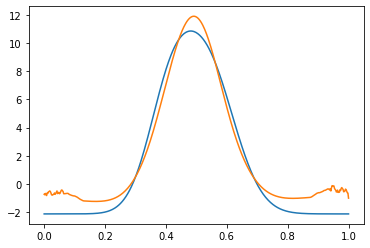

In [11]:
plt.plot(x, dT_dn[0])
plt.plot(x, tf.squeeze(model(n[0].reshape((1, 500, 1)).astype(np.float32))['dT_dn']))